In [ ]:
!pip3 install spflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 63.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.3/358.3 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 13.5 MB/s eta 0:00:00
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4967 sha256=26fff87aa9f15f6554fa366ddb483bd295c69b3eb38bac39908867dd59c7ec20
  Stored in directory: /root/.cache/pip/wheels/5e/d6/66/a25682c020fb563800fea1a06de58e4684243efd68cb83db83
  Created wheel for ete3: filename=ete3-3.1.2-

In [56]:
pip install psutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
# Main File for Learned Index

import pandas as pd
import time, gc, json
import numpy as np
import os, sys, getopt
import psutil



class BTreeNode:
    def __init__(self, degree=2, numberOfKeys=0, isLeaf=True, items=None, child=None,
                 index=None):
        self.isLeaf = isLeaf
        self.numberOfKeys = numberOfKeys
        self.index = index
        if items is not None:
            self.items = items
        else:
            self.items = [None] * (degree * 2 - 1)
        if child is not None:
            self.children = child
        else:
            self.children = [None] * degree * 2

    def set_index(self, index):
        self.index = index

    def get_index(self):
        return self.index

    def search(self, bTree, anItem):
        i = 0
        while i < self.numberOfKeys and anItem > self.items[i]:
            i += 1
        if i < self.numberOfKeys and anItem == self.items[i]:
            return {'found': True, 'fileIndex': self.index, 'nodeIndex': i}
        if self.isLeaf:
            return {'found': False, 'fileIndex': self.index, 'nodeIndex': i - 1}
        else:
            return bTree.get_node(self.children[i]).search(bTree, anItem)

class BTree:
    def __init__(self, degree=2, nodes=None, rootIndex=1, freeIndex=2):
        if nodes is None:
            nodes = {}
        self.degree = degree
        if len(nodes) == 0:
            self.rootNode = BTreeNode(degree)
            self.nodes = {}
            self.rootNode.set_index(rootIndex)
            self.write_at(1, self.rootNode)
        else:
            self.nodes = nodes
            self.rootNode = self.nodes[rootIndex]
        self.rootIndex = rootIndex
        self.freeIndex = freeIndex

    def build(self, key, value):
        if len(key) != len(value):
            return
        for i in range(len(key)):
            self.insert(Item(key[i], value[i]))

    def search(self, anItem):
        return self.rootNode.search(self, anItem)

    def predict(self, key):
        searchResult = self.search(Item(key, 0))
        aNode = self.nodes[searchResult['fileIndex']]
        if aNode.items[searchResult['nodeIndex']] is None:
            return -1
        return aNode.items[searchResult['nodeIndex']].v

    def split_child(self, pNode, i, cNode):
        newNode = self.get_free_node()
        newNode.isLeaf = cNode.isLeaf
        newNode.numberOfKeys = self.degree - 1
        for j in range(0, self.degree - 1):
            newNode.items[j] = cNode.items[j + self.degree]
        if cNode.isLeaf is False:
            for j in range(0, self.degree):
                newNode.children[j] = cNode.children[j + self.degree]
        cNode.numberOfKeys = self.degree - 1
        j = pNode.numberOfKeys + 1
        while j > i + 1:
            pNode.children[j + 1] = pNode.children[j]
            j -= 1
        pNode.children[j] = newNode.get_index()
        j = pNode.numberOfKeys
        while j > i:
            pNode.items[j + 1] = pNode.items[j]
            j -= 1
        pNode.items[i] = cNode.items[self.degree - 1]
        pNode.numberOfKeys += 1

    def insert(self, anItem):
        searchResult = self.search(anItem)
        if searchResult['found']:
            return None
        r = self.rootNode
        if r.numberOfKeys == 2 * self.degree - 1:
            s = self.get_free_node()
            self.set_root_node(s)
            s.isLeaf = False
            s.numberOfKeys = 0
            s.children[0] = r.get_index()
            self.split_child(s, 0, r)
            self.insert_not_full(s, anItem)
        else:
            self.insert_not_full(r, anItem)

    def insert_not_full(self, inNode, anItem):
        i = inNode.numberOfKeys - 1
        if inNode.isLeaf:
            while i >= 0 and anItem < inNode.items[i]:
                inNode.items[i + 1] = inNode.items[i]
                i -= 1
            inNode.items[i + 1] = anItem
            inNode.numberOfKeys += 1
        else:
            while i >= 0 and anItem < inNode.items[i]:
                i -= 1
            i += 1
            if self.get_node(inNode.children[i]).numberOfKeys == 2 * self.degree - 1:
                self.split_child(inNode, i, self.get_node(inNode.children[i]))
                if anItem > inNode.items[i]:
                    i += 1
            self.insert_not_full(self.get_node(inNode.children[i]), anItem)

    def delete(self, anItem):
        anItem = Item(anItem, 0)
        searchResult = self.search(anItem)
        if searchResult['found'] is False:
            return None
        r = self.rootNode
        self.delete_in_node(r, anItem, searchResult)

    def delete_in_node(self, aNode, anItem, searchResult):
        if aNode.index == searchResult['fileIndex']:
            i = searchResult['nodeIndex']
            if aNode.isLeaf:
                while i < aNode.numberOfKeys - 1:
                    aNode.items[i] = aNode.items[i + 1]
                    i += 1
                aNode.numberOfKeys -= 1
            else:
                left = self.get_node(aNode.children[i])
                right = self.get_node(aNode.children[i + 1])
                if left.numberOfKeys >= self.degree:
                    aNode.items[i] = self.get_right_most(left)
                elif right.numberOfKeys >= self.degree:
                    aNode.items[i] = self.get_right_most(right)
                else:
                    k = left.numberOfKeys
                    left.items[left.numberOfKeys] = anItem
                    left.numberOfKeys += 1
                    for j in range(0, right.numberOfKeys):
                        left.items[left.numberOfKeys] = right.items[j]
                        left.numberOfKeys += 1
                    del self.nodes[right.get_index()]
                    for j in range(i, aNode.numberOfKeys - 1):
                        aNode.items[j] = aNode.items[j + 1]
                        aNode.children[j + 1] = aNode.children[j + 2]
                    aNode.numberOfKeys -= 1
                    if aNode.numberOfKeys == 0:
                        del self.nodes[aNode.get_index()]
                        self.set_root_node(left)
                    self.delete_in_node(left, anItem, {'found': True, 'fileIndex': left.index, 'nodeIndex': k})
        else:
            i = 0
            while i < aNode.numberOfKeys and self.get_node(aNode.children[i]).search(self, anItem)['found'] is False:
                i += 1
            c_node = self.get_node(aNode.children[i])
            if c_node.numberOfKeys < self.degree:
                j = i - 1
                while j < i + 2 and self.get_node(aNode.children[j]).numberOfKeys < self.degree:
                    j += 1
                if j == i - 1:
                    sNode = self.get_node(aNode.children[j])
                    k = c_node.numberOfKeys
                    while k > 0:
                        c_node.items[k] = c_node.items[k - 1]
                        c_node.children[k + 1] = c_node.children[k]
                        k -= 1
                    c_node.children[1] = c_node.children[0]
                    c_node.items[0] = aNode.items[i - 1]
                    c_node.children[0] = sNode.children[sNode.numberOfKeys]
                    c_node.numberOfKeys += 1
                    aNode.items[i - 1] = sNode.items[sNode.numberOfKeys - 1]
                    sNode.numberOfKeys -= 1
                elif j == i + 1:
                    sNode = self.get_node(aNode.children[j])
                    c_node.items[c_node.numberOfKeys] = aNode.items[i]
                    c_node.children[c_node.numberOfKeys + 1] = sNode.children[0]
                    aNode.items[i] = sNode.items[0]
                    for k in range(0, sNode.numberOfKeys):
                        sNode.items[k] = sNode.items[k + 1]
                        sNode.children[k] = sNode.children[k + 1]
                    sNode.children[k] = sNode.children[k + 1]
                    sNode.numberOfKeys -= 1
                else:
                    j = i + 1
                    sNode = self.get_node(aNode.children[j])
                    c_node.items[c_node.numberOfKeys] = aNode.items[i]
                    c_node.numberOfKeys += 1
                    for k in range(0, sNode.numberOfKeys):
                        c_node.items[c_node.numberOfKeys] = sNode.items[k]
                        c_node.numberOfKeys += 1
                    del self.nodes[sNode.index]
                    for k in range(i, aNode.numberOfKeys - 1):
                        aNode.items[i] = aNode.items[i + 1]
                        aNode.children[i + 1] = aNode.items[i + 2]
                    aNode.numberOfKeys -= 1
                    if aNode.numberOfKeys == 0:
                        del self.nodes[aNode.index]
                        self.set_root_node(c_node)
            self.delete_in_node(c_node, anItem, c_node.search(self, anItem))

    def get_right_most(self, aNode):
        if aNode.children[aNode.numberOfKeys] is None:
            upItem = aNode.items[aNode.numberOfKeys - 1]
            self.delete_in_node(aNode, upItem,
                                {'found': True, 'fileIndex': aNode.index, 'nodeIndex': aNode.numberOfKeys - 1})
            return upItem
        else:
            return self.get_right_most(self.get_node(aNode.children[aNode.numberOfKeys]))

    def set_root_node(self, r):
        self.rootNode = r
        self.rootIndex = self.rootNode.get_index()

    def get_node(self, index):
        return self.nodes[index]

    def get_free_node(self):
        new_node = BTreeNode(self.degree)
        index = self.get_free_index()
        new_node.set_index(index)
        self.write_at(index, new_node)
        return new_node

    def get_free_index(self):
        self.freeIndex += 1
        return self.freeIndex - 1

    def write_at(self, index, a_node):
        self.nodes[index] = a_node

class Item():
    def __init__(self, k, v):
        self.k = k
        self.v = v

    def __gt__(self, other):
        if self.k > other.k:
            return True
        else:
            return False

    def __ge__(self, other):
        if self.k >= other.k:
            return True
        else:
            return False

    def __eq__(self, other):
        if self.k == other.k:
            return True
        else:
            return False

    def __le__(self, other):
        if self.k <= other.k:
            return True
        else:
            return False

    def __lt__(self, other):
        if self.k < other.k:
            return True
        else:
            return False

       
# main function for training index
def train_index(path):
    data = pd.read_csv(path)
    train_set_x = []
    train_set_y = []
    test_set_x = []
    test_set_y = []
    global TOTAL_NUMBER
    TOTAL_NUMBER = data.shape[0]
    for i in range(data.shape[0]):
        train_set_x.append(data.iloc[i, 0])
        train_set_y.append(data.iloc[i, 1])

    test_set_x = train_set_x[:1000]
    test_set_y = train_set_y[:]   
    # build BTree index
    bt = BTree(128)
    print("Started Building")
    start_time = time.time()
    bt.build(train_set_x, train_set_y)
    end_time = time.time()
    build_time = end_time - start_time
    print("Build BTree time ", build_time)
    err = 0
    start_time = time.time()
    pre=[]
    for i in test_set_x:
      pre.append(bt.predict(i))
    end_time = time.time()
    search_time = (end_time - start_time)
    print("Search time for 1000 keys", search_time)
       
if __name__ == "__main__":
    train_index("https://raw.githubusercontent.com/sachinchowdary/Datasets/main/integerdataset")
    process = psutil.Process()
    mem_info = process.memory_info().rss
    mem_usage = mem_info/ 1024 / 1024
    print(f"Memory usage: {mem_usage:.2f} MB")


Started Building
Build BTree time  2.740764856338501
Search time for 1000 keys 0.027470111846923828
Memory usage: 878.88 MB


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Build Time: 1.54606294631958
Structure Stats: ---Structure Statistics---
# nodes             7
    # sum nodes     1
    # prod nodes    2
    # leaf nodes    4
# params            10
# edges             6
# layers            3
SPN Structure
time taken to search 1000 Keys 0.002416849136352539
Memory usage: 878.89 MB


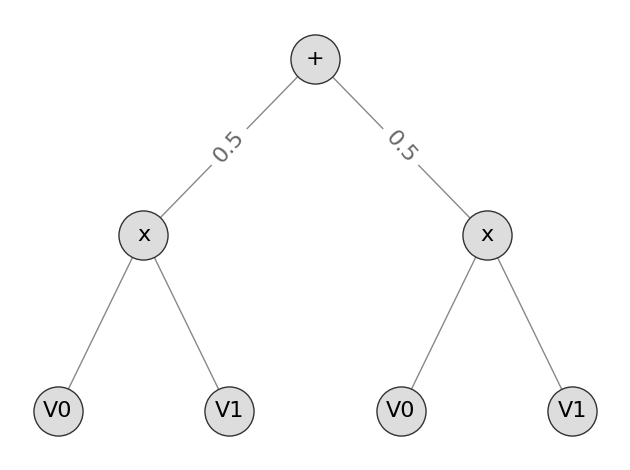

In [113]:
import numpy as np
import pandas as pd
import time
from spn.structure.Base import Context
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.algorithms.LearningWrappers import learn_parametric
from spn.algorithms.Statistics import get_structure_stats
from spn.io.Graphics import plot_spn
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.MPE import mpe
from spn.structure.Base import assign_ids, rebuild_scopes_bottom_up
import psutil

data = pd.read_csv("https://raw.githubusercontent.com/sachinchowdary/Datasets/main/integerdataset")
train_data = data.to_numpy()
test_data=train_data[:1000] 
num_vars = train_data.shape[1]  # Number of variables in the dataset
ds_context = Context(parametric_types=[Gaussian, Gaussian]).add_domains(train_data) 

start_time=time.time()   
spn = learn_parametric(train_data, ds_context)
end_time=time.time()

print("Build Time:",end_time-start_time)
print("Structure Stats:",get_structure_stats(spn))
print("SPN Structure")
plot_spn(spn, 'basicspn.png')


start_time=time.time()  
ll = log_likelihood(spn, test_data)
end_time=time.time()
print("time taken to search 1000 Keys",end_time-start_time)
#print(ll)

# Get the current process object
process = psutil.Process()
# Get the memory usage in bytes
mem_info = process.memory_info().rss
# Convert to megabytes
mem_usage = mem_info / 1024 / 1024
print(f"Memory usage: {mem_usage:.2f} MB")
